In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import argparse
import sys
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from utils import *

In [2]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [3]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Jun_13_19:16:58_PDT_2023
Cuda compilation tools, release 12.2, V12.2.91
Build cuda_12.2.r12.2/compiler.32965470_0


# Load data

In [4]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"

In [5]:
two= True
blurry = True

In [20]:
pairs_path = f"{data_path}/train_test_val/pairs_validation.csv"
coord_path = f"{data_path}/alphabets_blosum_coordinates/allCACoord.npz"
oh1_path = f"{data_path}/alphabets_blosum_coordinates/MSE/MSE.npz"
blosum1_path = f"{data_path}/alphabets_blosum_coordinates/MSE/MSE.npy"
lddts_given_path = f"{data_path}/train_test_val/pairs_validation_lddts.csv"
if two:
    oh2_path = f"{data_path}/alphabets_blosum_coordinates/3Di/3Di.npz"
    blosum2_path = f"{data_path}/alphabets_blosum_coordinates/3Di/3Di.npy"
if blurry:
    nh_path = f"{data_path}/alphabets_blosum_coordinates/blurry_vecs.npz"
    tmat_path = f"{data_path}/alphabets_blosum_coordinates/transition_mtx.npy"
    jbl_path = f"{data_path}/alphabets_blosum_coordinates/jaccard_blosum_int.npy"

## check that databases have same keys and same length sequences

In [7]:
#hot_d; protien_name: L by alphabet size or num bins + 1; encode sequence in alphabet or nhots
#coord_d; protein_name: L by 3; encodes 3D coordinates

In [8]:
coord_d = np.load(coord_path)
oh_d1 = np.load(oh1_path)
#blosum1 = np.load(blosum1_path)[:-1,:-1].astype(float)
blosum1 = np.load(blosum1_path).astype(float)
if two:
    oh_d2 = np.load(oh2_path)
    blosum2 = np.load(blosum2_path).astype(float)
 #   blosum2 = np.load(blosum2_path)[:-1,:-1].astype(float)
print(blosum1.shape)


(20, 20)


In [9]:
if False:
    # MANUAL ADJUSTMENT OF 3Di BLOSUM 
    arr = blosum2
    zeros_row = jnp.zeros((1, arr.shape[1]))
    arr_with_row = jnp.vstack([arr, zeros_row])

    # Add a column of zeros on the right
    zeros_col = jnp.zeros((arr_with_row.shape[0], 1))
    arr_with_row_and_col = jnp.hstack([arr_with_row, zeros_col])
    blosum2 = arr_with_row_and_col

In [10]:
# check sizes of alphabets
if oh_d1[list(oh_d1.keys())[0]].shape[1]!=blosum1.shape[1]:
        raise ValueError(f"one-hot encoding length does not match blosum shape {blosum1.shape[1]}")
if two:  
    if oh_d2[list(oh_d2.keys())[0]].shape[1]!=blosum2.shape[1]:
        raise ValueError(f"one-hot encoding length does not match blosum2 shape {blosum2.shape[1]}")

In [11]:
# check overlap of keys and sequence lengths
bad_list = check_keys_and_lengths(oh_d1, coord_d)
print(bad_list)
if two:
    bad_list2 = check_keys_and_lengths(oh_d2, coord_d)
    print(bad_list2)
    bad_list += bad_list2
print(len(bad_list))

in hot_d but not coord_d:
set()
in coord_d but not hot_d:
{'d1o7d.2', 'd1o7d.3'}
['d1o7d.2', 'd1o7d.3']
in hot_d but not coord_d:
set()
in coord_d but not hot_d:
{'d1o7d.2', 'd1o7d.3'}
['d1o7d.2', 'd1o7d.3']
4


## load in validation pairs, lddt of given aln, and their TMscores

In [12]:
# remove anything with 'd1e25a_' since we seem to be having some length issues
# remove any pairs with length > 512 
bad_list.append('d1e25a_')
pairs = []
alns_as_lists = []
first = True
tm_d = {}
n2l_d = make_name_to_length_d(oh_d1)
with open(pairs_path, mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        pair = (row[1],row[2])
        if first:
            first = False
            continue    
        elif pair[0] in bad_list or pair[1] in bad_list:
            continue
        elif n2l_d[pair[0]]>512 or n2l_d[pair[1]]>512:
            continue
        else:
            pairs.append(pair)
            tm_d[pair]= float(row[3])
            alns_as_lists.append([int(i) for i in row[-1].strip('[]').split()])
print(len(pairs))

2828


In [13]:
# load lddt given by alignments in validation_pairs.csv 
# computed in /cluster/tufts/pettilab/spetti04/structure_comparison/benchmarking/lddt_for_precomputed_alns.ipynb

given_lddt_d = {}

# Open the CSV file for reading
with open(lddts_given_path, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        a, b, value = row[0], row[1], float(row[2])  # Convert value to float
        given_lddt_d[(a, b)] = value

print(len(given_lddt_d.keys()))

check_keys(given_lddt_d, tm_d)

2828
all keys match


[]

## Sort for better batching

In [14]:
# sort pairs by length of longer protein
pair_max_length_pairs = [(pair, max(n2l_d[pair[0]], n2l_d[pair[1]])) for pair in pairs]
sorted_keys = sorted(pair_max_length_pairs, key=lambda x: x[1])
sorted_pairs = [key for key, shape in sorted_keys]
pairs = sorted_pairs

In [15]:
# get lists of given lddt and tm score in the order that we will get our results
given_lddt_list = [given_lddt_d[p] for p in pairs]
tm_list = [tm_d[p] for p in pairs]

## Plot lddt vs TM score for given alignments

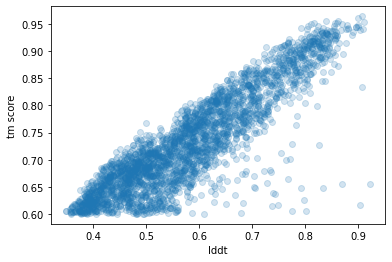

In [16]:
plt.scatter(given_lddt_list, tm_list, alpha = .2)
plt.xlabel("lddt")
plt.ylabel("tm score")
plt.show()

# Run alignment benchmark

In [17]:
def run_in_batches(long_list, batch_size, params, data):
    result = []
    for i in range(0, len(long_list), batch_size):
        batch = long_list[i:i + batch_size]  # Get the current batch
        result.extend(run_batch(batch, params, data))   # Process and extend results
        print(f"finished batch {i}")
    return result

def run_batch(pairs, params, data):

    oh_d= data["oh_d"]
    blosum = data["blosum"]
    if params["use_two"]:
        oh_d2 = data["oh_d2"]
        blosum2 = data["blosum2"]

    # compute max length of any protein
    names=[item for tup in pairs for item in tup]
    max_len = max([n2l_d[name] for name in names])
    pad_to = int(jnp.where(max_len < 1, 1, 2 ** jnp.ceil(jnp.log2(max_len))))
    #print(pad_to)

    #print(max([oh_d[pair[0]].shape[0] for pair in pairs]))
    # get oh and coords for left and right part of pairs, padded
    lefts, left_lengths = pad_and_stack_manual([oh_d[pair[0]] for pair in pairs],pad_to = pad_to)
    rights, right_lengths = pad_and_stack_manual([oh_d[pair[1]] for pair in pairs], pad_to = pad_to)
    
    if params["use_two"]:
        lefts2, _ = pad_and_stack_manual([oh_d2[pair[0]] for pair in pairs],pad_to = pad_to)
        rights2, _ = pad_and_stack_manual([oh_d2[pair[1]] for pair in pairs], pad_to = pad_to)

    left_coords, _ = pad_and_stack_manual([coord_d[pair[0]] for pair in pairs],pad_to = pad_to)
    right_coords, _ = pad_and_stack_manual([coord_d[pair[1]] for pair in pairs], pad_to = pad_to)

    # make similarity matrices
    if params["blurry"]:
        sim_tensor = vv_sim_mtx_blurry(lefts, rights, blosum)
        sim_tensor = v_replace_jaccard_w_blosum_score(sim_tensor, params["jaccard_blosum"])
    else:
        sim_tensor = vv_sim_mtx(lefts, rights, blosum)
        if params["use_two"]:
            sim_tensor *= params["w1"]
            sim_tensor += params["w2"]*vv_sim_mtx(lefts2, rights2, blosum2)

    # align (gap, open, temp)
    length_pairs = jnp.column_stack([left_lengths, right_lengths])
    aln_tensor = v_aln_w_sw(sim_tensor, length_pairs, params["gap_extend"], params["gap_open"], params["temp"])
    aln_tensor = (aln_tensor>params["soft_aln_thresh"]).astype(int)

    # compute lddts 
    lddts = vv_lddt(left_coords, right_coords, aln_tensor, jnp.sum(aln_tensor, axis = [-2,-1]), jnp.array(left_lengths))

    return lddts

# Grid searches 

In [18]:
open_choices = np.arange(-20,0,2)
extend_choices =np.arange(-3,.3,0.5)
print(open_choices)
print(extend_choices)

[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2]
[-3.  -2.5 -2.  -1.5 -1.  -0.5  0. ]


In [21]:
def plot(lddt_d, mode = "mean"):# Example dictionary (replace this with your actual data)
    data_dict = lddt_d

    # Get all unique x (o) and y (e) values
    x_values = sorted(set(o for o, e in data_dict.keys()))
    y_values = sorted(set(e for o, e in data_dict.keys()))

    # Create an empty 2D array to store the median values
    grid = np.zeros((len(y_values), len(x_values)))

    # Fill the grid with the median of the lists
   
    for (o, e), values in data_dict.items():
        if mode == "mean":
            val = np.mean(values)
        elif mode == "spearman_lddt":
            val =  ss.spearmanr(values, given_lddt_list).correlation
        elif mode == "spearman_tm":
            val =  ss.spearmanr(values, tm_list).correlation
        elif mode == "geo_mean":
            val=(ss.spearmanr(values, given_lddt_list).correlation*np.mean(values))**(1/2.0)
        x_idx = x_values.index(o)
        y_idx = y_values.index(e)
        grid[y_idx, x_idx] = val
    # Create the heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(grid, xticklabels=x_values, yticklabels=y_values, cmap='Blues', annot=True)

    # Add labels and title
    plt.xlabel('o values (x-axis)')
    plt.ylabel('e values (y-axis)')
    plt.title(f'{mode} heatmap')

    # Show the plot
    plt.show()

In [29]:
def get_max_key_by_spearman(your_dict):
    return max(your_dict, key=lambda key: ss.spearmanr(your_dict[key], given_lddt_list).correlation)

## Single alphabets

In [23]:
params = {}
params["gap_extend"] = None
params["gap_open"] = None
params["temp"] = 1e-3 # do not change
params["soft_aln_thresh"]=.5 # do not change
params["use_two"]= False
params["w1"] = None
params["w2"] = None
params["blurry"] = None
params["jaccard_blosum"] = None

### 3Dn via VQVAE with MSE

In [40]:
data = {}
data["blosum"] = blosum1
data["oh_d"] = oh_d1

In [41]:
%%time
# faster with batch size 200 if you have sufficient memory for it
lddt_d = {}

for o in open_choices:
    for e in extend_choices:
        print(o,e)
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)


-20 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -2.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -1.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished ba

finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -2.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 12

finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-6 0.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-4 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-4 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 180

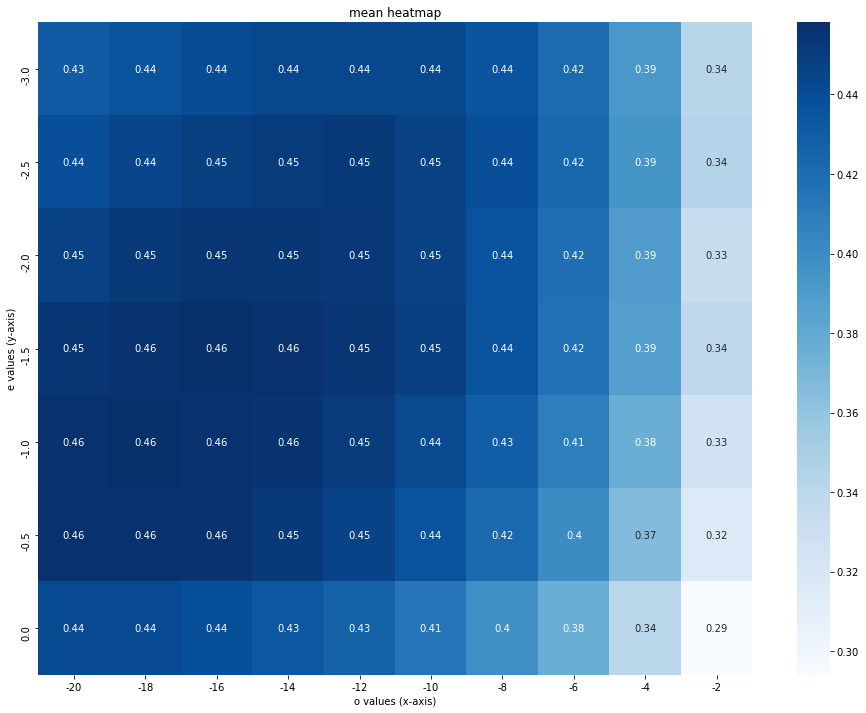

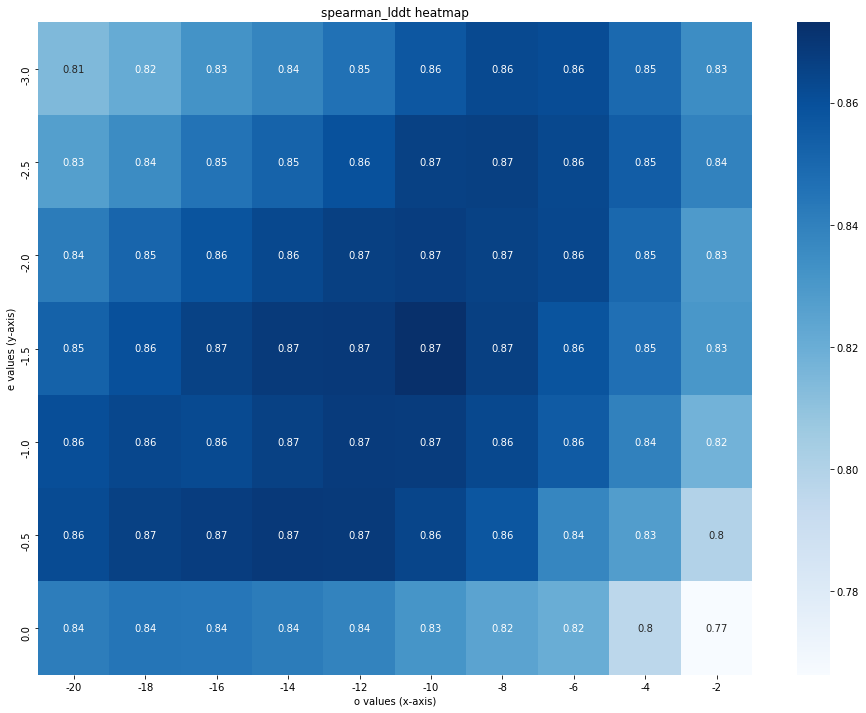

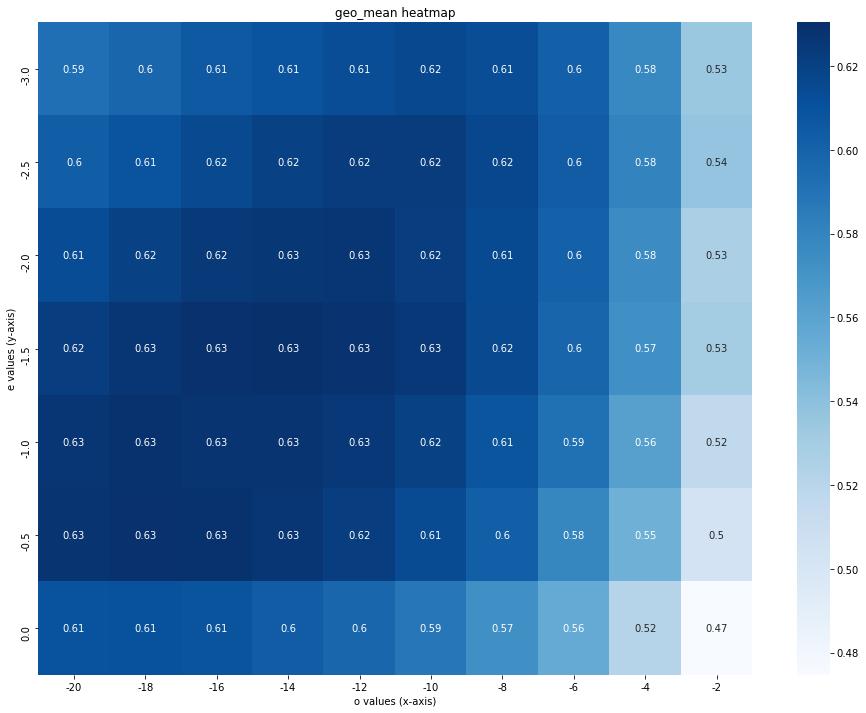

(-10, -1.5)


In [42]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "geo_mean")
print(get_max_key_by_spearman(lddt_d))

### 3Di

In [31]:
data = {}
data["blosum"] = blosum2
data["oh_d"] = oh_d2

In [32]:
%%time
# faster with batch size 200 if you have sufficient memory for it
lddt_d = {}

for o in open_choices:
    for e in extend_choices:
        print(o,e)
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)

-20 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -2.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -1.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished ba

finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -2.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 12

finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-6 0.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-4 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-4 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 180

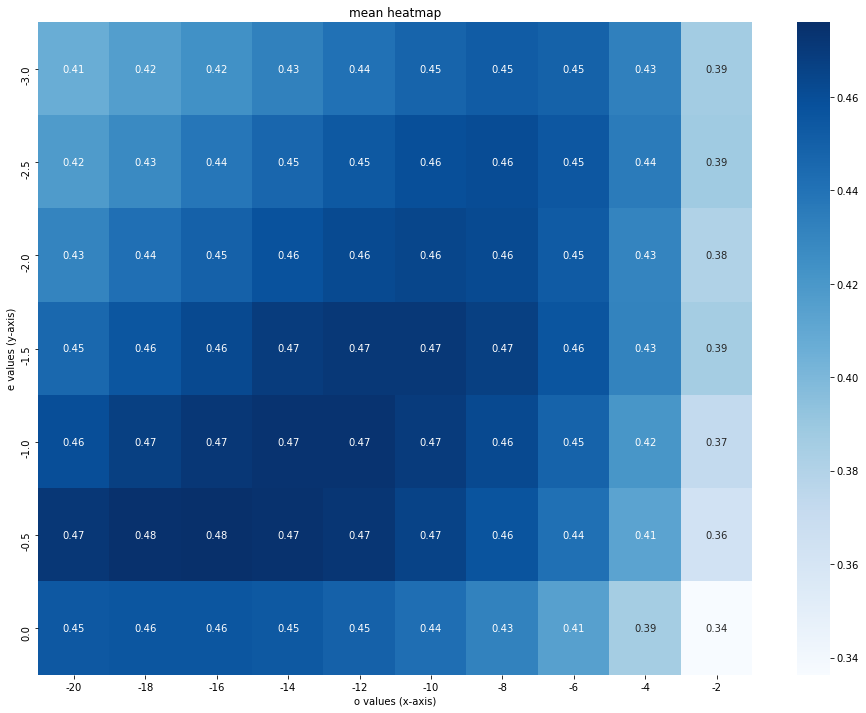

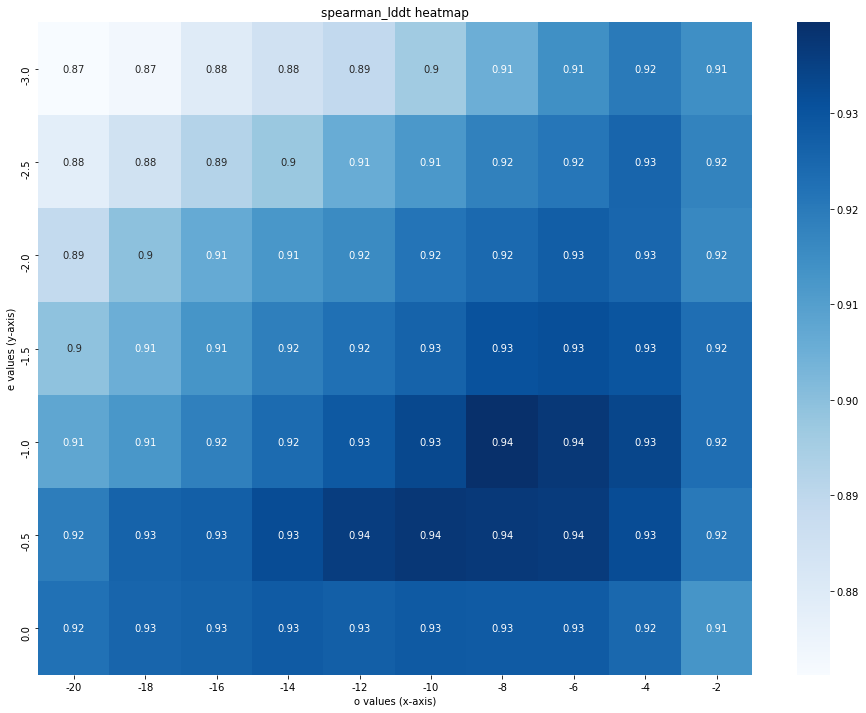

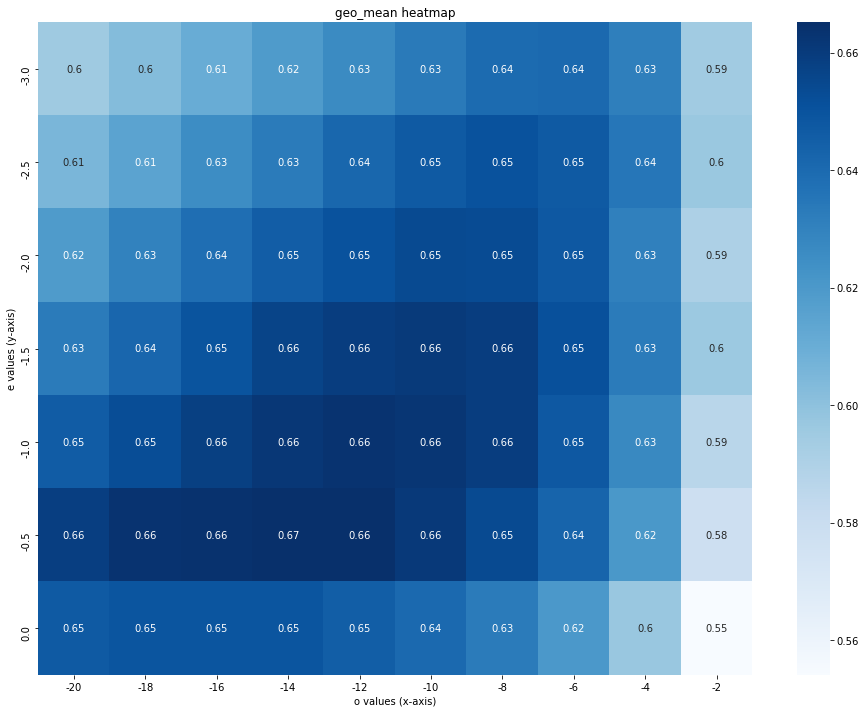

(-8, -1.0)


In [39]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "geo_mean")
print(get_max_key_by_spearman(lddt_d))

In [36]:
ss.spearmanr(lddt_d[(-8,-1.0)], given_lddt_list).correlation 

0.9395306167780977

In [37]:
ss.spearmanr(lddt_d[(-10,-1.0)], given_lddt_list).correlation 

0.933237298767187

## Multiple alphabets

### Even mix of 3Dn and 3Di

In [43]:
params = {}
params["gap_extend"] = None
params["gap_open"] = None
params["temp"] = 1e-3 # do not change
params["soft_aln_thresh"]=.5 # do not change
params["use_two"]= True
params["w1"] = 1.0
params["w2"] = 1.0
params["blurry"] = None
params["jaccard_blosum"] = None

In [44]:
%%time
lddt_d = {}

data = {}
data["blosum"] = blosum1
data["oh_d"] = oh_d1
data["blosum2"] = blosum2
data["oh_d2"] = oh_d2

for o in open_choices:
    for e in extend_choices:
        print(o,e)
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 200, params, data)

-20 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -2.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-20 -1.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished ba

finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-12 -2.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 12

finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-6 0.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-4 -3.0
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 1800
finished batch 2000
finished batch 2200
finished batch 2400
finished batch 2600
finished batch 2800
-4 -2.5
finished batch 0
finished batch 200
finished batch 400
finished batch 600
finished batch 800
finished batch 1000
finished batch 1200
finished batch 1400
finished batch 1600
finished batch 180

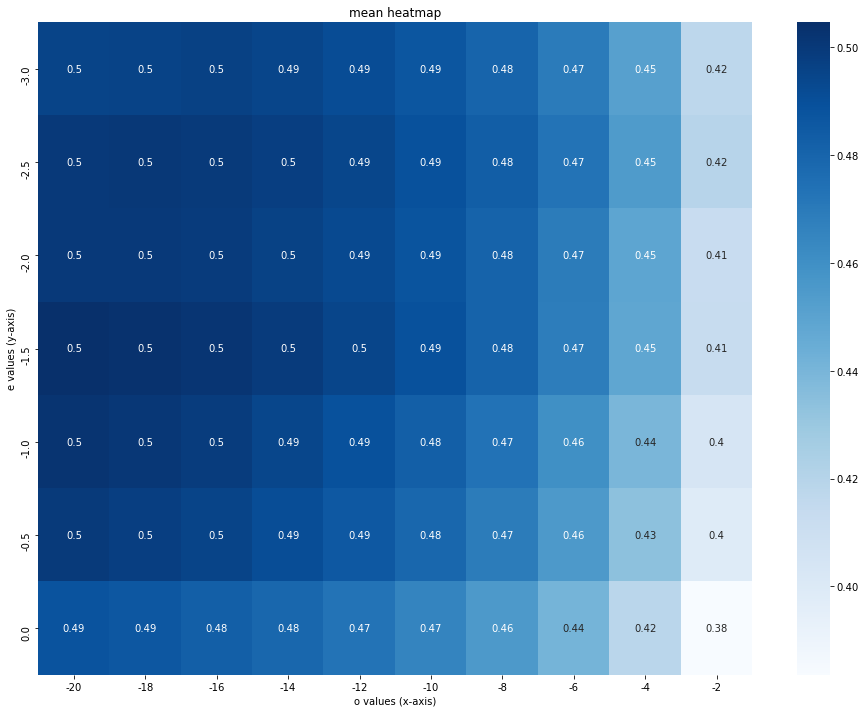

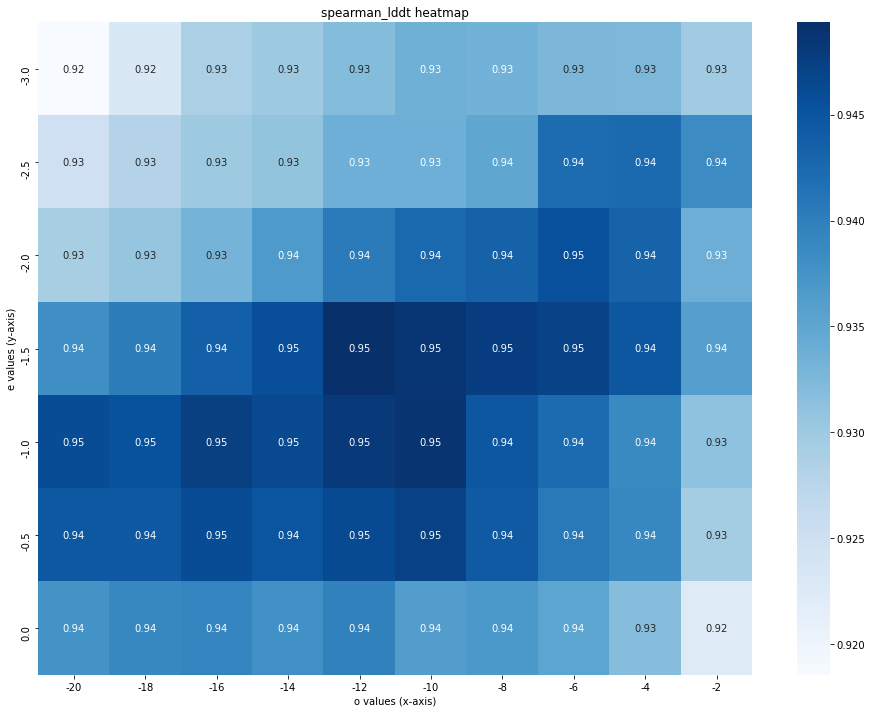

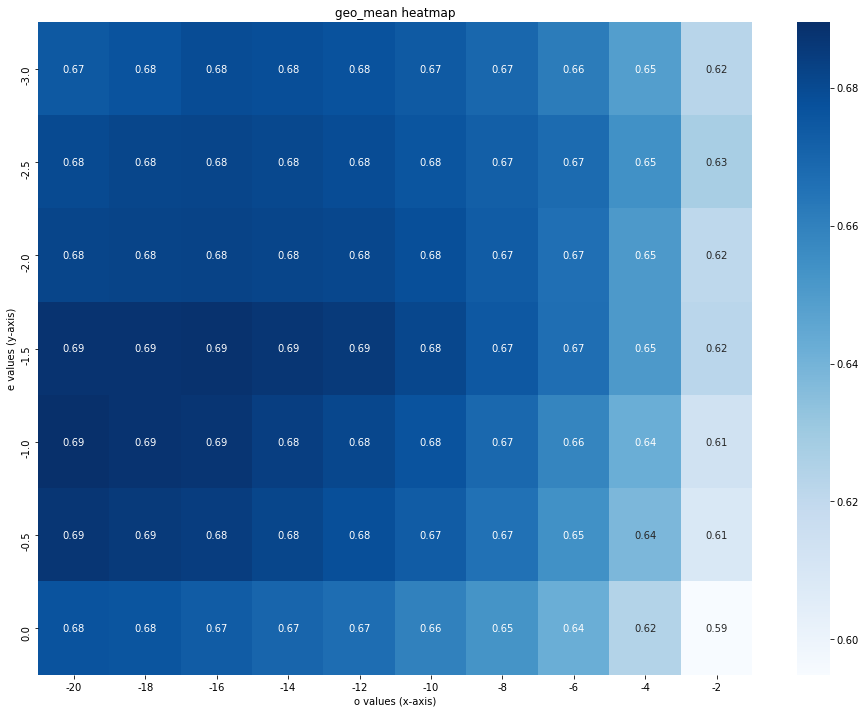

(-12, -1.5)


In [45]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "geo_mean")
print(get_max_key_by_spearman(lddt_d))

## Blurry vectors

In [53]:
params = {}
params["gap_extend"] = None
params["gap_open"] = None
params["temp"] = 1e-3 # do not change
params["soft_aln_thresh"]=.5 # do not change
params["use_two"]= None
params["w1"] = None
params["w2"] = None
params["blurry"] = True
params["jaccard_blosum"] = jaccard_blosum +0.0

In [54]:
%%time
lddt_d = {}

data = {}
data["blosum"] = np.load(tmat_path)
data["oh_d"] = np.load(nh_path)


for o in open_choices:
    for e in extend_choices:
        print(o,e)
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 100, params, data)

-20 -3.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished batch 1800
finished batch 1900
finished batch 2000
finished batch 2100
finished batch 2200
finished batch 2300
finished batch 2400
finished batch 2500
finished batch 2600
finished batch 2700
finished batch 2800
-20 -2.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished batch 1800
finished batch 1900
finished batch 2000
finish

finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished batch 1800
finished batch 1900
finished batch 2000
finished batch 2100
finished batch 2200
finished batch 2300
finished batch 2400
finished batch 2500
finished batch 2600
finished batch 2700
finished batch 2800
-16 -2.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished batch 1800
finished batch 1900
finished batch 2000
finished batch 2100
finished batch 2200
finished batch 2300
finished batch 2400
finished batch 2500
finished batch 2600
finishe

finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished batch 1800
finished batch 1900
finished batch 2000
finished batch 2100
finished batch 2200
finished batch 2300
finished batch 2400
finished batch 2500
finished batch 2600
finished batch 2700
finished batch 2800
-12 -2.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished batch 1800
finished batch 1900
finished batch 2000
finished batch 2100
finished batch 2200
finished batch 2300
finished batch 2400
finished batch 2500
finished batch 2600
finished batch 2700
finished batch 2800
-12 -2.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
f

finished batch 1900
finished batch 2000
finished batch 2100
finished batch 2200
finished batch 2300
finished batch 2400
finished batch 2500
finished batch 2600
finished batch 2700
finished batch 2800
-8 -2.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished batch 1800
finished batch 1900
finished batch 2000
finished batch 2100
finished batch 2200
finished batch 2300
finished batch 2400
finished batch 2500
finished batch 2600
finished batch 2700
finished batch 2800
-8 -2.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished

finished batch 2600
finished batch 2700
finished batch 2800
-4 -2.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished batch 1800
finished batch 1900
finished batch 2000
finished batch 2100
finished batch 2200
finished batch 2300
finished batch 2400
finished batch 2500
finished batch 2600
finished batch 2700
finished batch 2800
-4 -2.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
finished batch 1600
finished batch 1700
finished

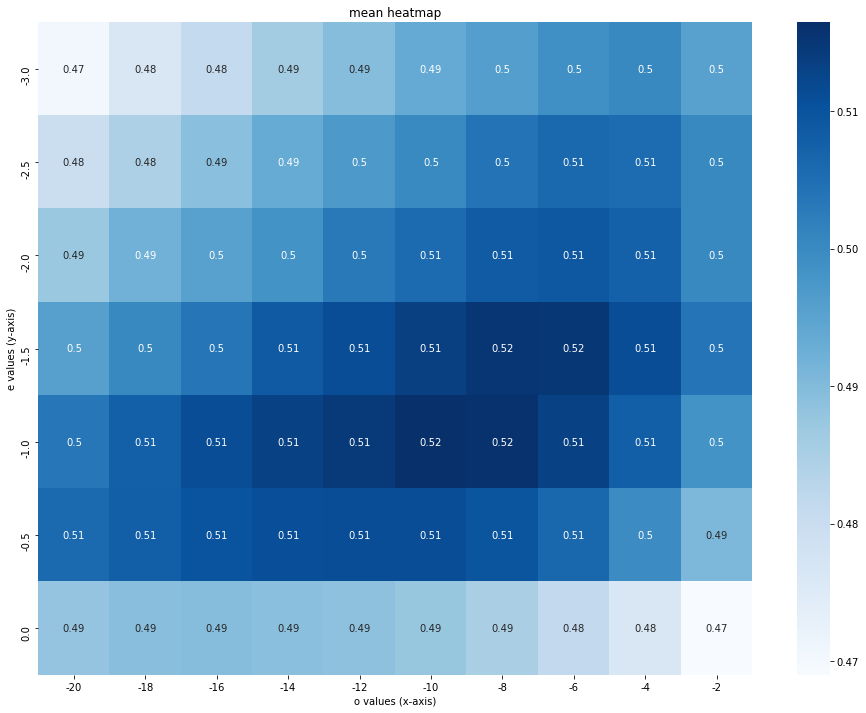

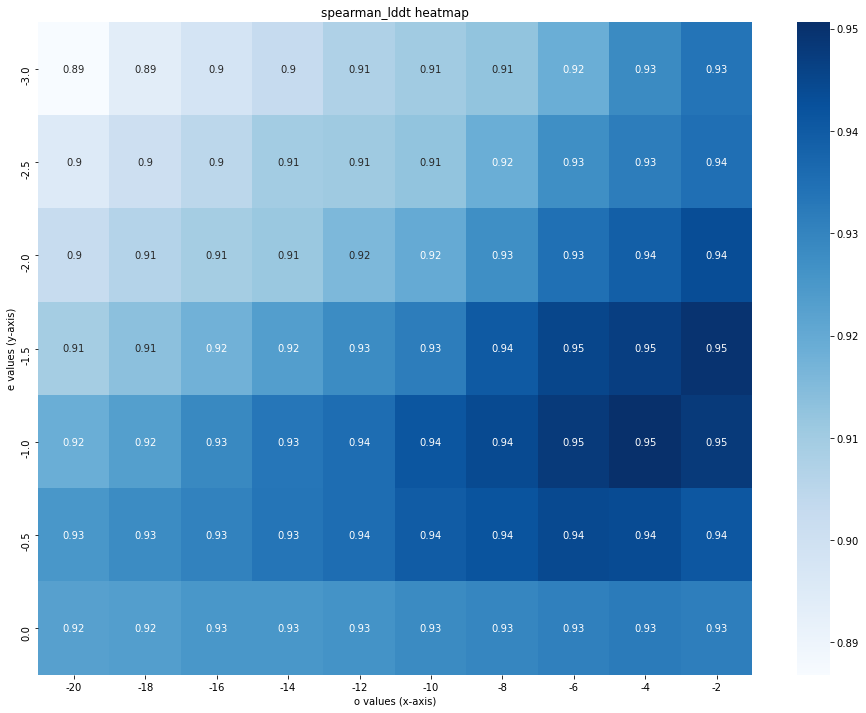

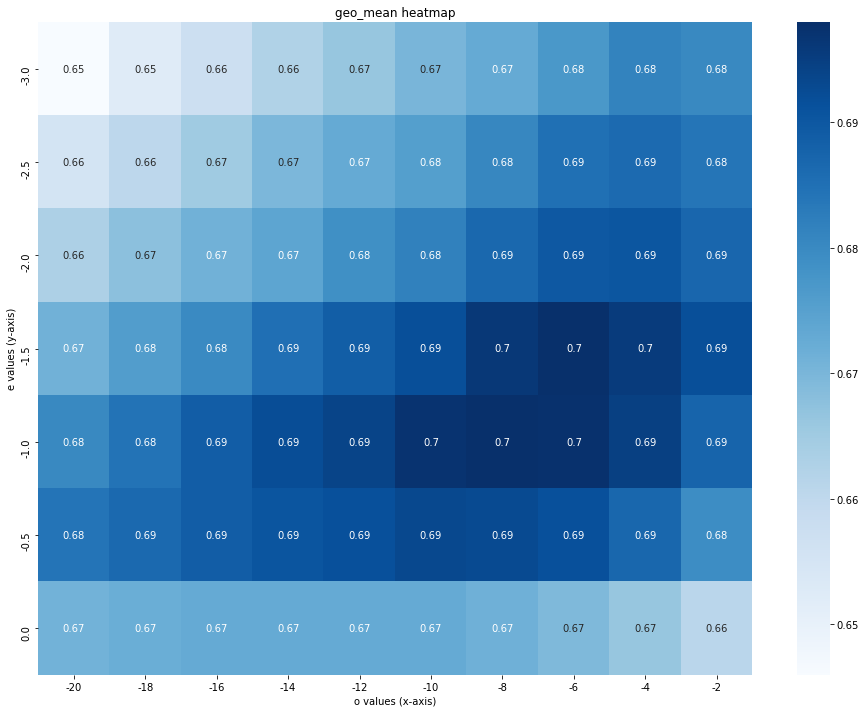

(-4, -1.0)


In [55]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "spearman_lddt")
plot(lddt_d, mode = "geo_mean")
print(get_max_key_by_spearman(lddt_d))

In [56]:
lddt_d

{(-20, -3.0): [0.8241445,
  0.801259,
  0.8174779,
  0.8345987,
  0.8699552,
  0.85825896,
  0.5762332,
  0.34463987,
  0.7749458,
  0.45908073,
  0.6754485,
  0.7310268,
  0.7909292,
  0.5093006,
  0.73357964,
  0.64040697,
  0.52063954,
  0.90722495,
  0.5592522,
  0.7705883,
  0.6366161,
  0.7317005,
  0.8044994,
  0.7483108,
  0.5870536,
  0.7261905,
  0.68449897,
  0.67693114,
  0.8124208,
  0.44739696,
  0.15337422,
  0.57302094,
  0.7058989,
  0.71970475,
  0.20584862,
  0.064965695,
  0.48995912,
  0.5849082,
  0.5898032,
  0.627265,
  0.45932606,
  0.6888432,
  0.47423553,
  0.30088493,
  0.3585787,
  0.47889718,
  0.33205885,
  0.6547979,
  0.50448656,
  0.41566515,
  0.5934315,
  0.5275698,
  0.40021876,
  0.57364094,
  0.46218488,
  0.38014153,
  0.15507247,
  0.7496596,
  0.46463296,
  0.568268,
  0.48343778,
  0.44057742,
  0.54487467,
  0.55506414,
  0.8196145,
  0.80972964,
  0.37744892,
  0.6189037,
  0.40264586,
  0.850145,
  0.8307256,
  0.79370403,
  0.82074857,
  0